In [3]:
import numpy as np
import scipy
from tqdm import trange
from tqdm.notebook import tqdm
import sys
import os

from matplotlib import pyplot as plt
import joblib
from joblib import Parallel, delayed, dump, load
from matplotlib import pyplot as plt
#import Sparse_vector
#sys.modules['sparse_vector'] = Sparse_vector
from Sparse_vector.sparse_vector import SparseVector


In [4]:
import torch
from torch.utils import data
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold

In [5]:
chroms = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]
all_features = [i[:-4] for i in os.listdir('z_dna/hg38_features/sparse/') if i.endswith('_2.pkl')]
groups = ['DNase-seq', 'Histone', 'RNA polymerase', 'TFs and others']
feature_names = [i for i in all_features]

def chrom_reader(chrom):
    files = sorted([i for i in os.listdir(f'z_dna/hg38_dna/') if f"{chrom}_" in i])
    return ''.join([load(f"z_dna/hg38_dna/{file}") for file in files])

In [6]:
from tqdm import tqdm
import sys
import time


In [5]:
%%time
DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chroms)}
# ZDNA_shin = load('z_dna/hg38_zdna/sparse/ZDNA_shin.pkl')
# ZDNA_cousine = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

DNA_features = {feature: load(f'z_dna/hg38_features/sparse/{feature}.pkl')
                for feature in tqdm(feature_names)}

100%|███████████████████████████████████████████████████████████████████████████████| 1946/1946 [00:55<00:00, 35.26it/s]

CPU times: user 54.7 s, sys: 5.04 s, total: 59.8 s
Wall time: 59.4 s


In [6]:
class Dataset(data.Dataset):
    def __init__(self, chroms, features, 
                 dna_source, features_source, 
                 labels_source, intervals):
        self.chroms = chroms
        self.features = features
        self.dna_source = dna_source
        self.features_source = features_source
        self.labels_source = labels_source
        self.intervals = intervals
        self.le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))
        
    def __len__(self):
        return len(self.intervals)
    
    def __getitem__(self, index):
        interval = self.intervals[index]
        chrom = interval[0]
        begin = int(interval[1])
        end = int(interval[2])
        dna_OHE = self.le.transform(list(self.dna_source[chrom][begin:end].upper()))
        
        feature_matr = []
        for feature in self.features:
            source = self.features_source[feature]
            feature_matr.append(source[chrom][begin:end])
        if len(feature_matr) > 0:
            X = np.hstack((dna_OHE, np.array(feature_matr).T/1000)).astype(np.float32)
        else:
            X = dna_OHE.astype(np.float32)
        y = self.labels_source[interval[0]][interval[1]: interval[2]]
        
        return (X, y)
        
        

In [7]:
width = 100


ints_in = []
ints_out = []

for chrm in chroms:
    for st in trange(0, ZDNA[chrm].shape - width, width):
        interval = [st, min(st + width, ZDNA[chrm].shape)]
        if ZDNA[chrm][interval[0]: interval[1]].any():
            ints_in.append([chrm, interval[0], interval[1]])
        else:
            ints_out.append([chrm, interval[0], interval[1]])

ints_in = np.array(ints_in)
ints_out = np.array(ints_out)[np.random.choice(range(len(ints_out)), size=len(ints_in) * 2, replace=False)]

100%|██████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 51469.59it/s]


In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
np.random.seed(42)
equalized = np.vstack((ints_in, ints_out))
equalized = [[inter[0], int(inter[1]), int(inter[2])] for inter in equalized]

labels = np.array([1]*len(ints_in) + [0]*len(ints_out))
chromes = [inter[0] for inter in equalized]
strat_labels = np.array([f"{label}_{chrom}" for label, chrom in zip(labels, chromes)])
print(strat_labels)
  
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_inds, test_inds = next(sss.split(equalized, strat_labels))
  
train_intervals, test_intervals = [equalized[i] for i in train_inds], [equalized[i] for i in test_inds]

['1_chr1' '1_chr1' '1_chr1' ... '0_chr2' '0_chr18' '0_chr2']


In [9]:
train_dataset = Dataset(chroms, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, train_intervals)

test_dataset = Dataset(chroms, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, test_intervals)

In [10]:
params = {'batch_size':1,
          'num_workers':20,
          'shuffle':True}

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

# CNN Model

In [11]:
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score
from IPython.display import clear_output

class DeepCNNSiLU_9L(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            
            nn.Conv2d(1, 3, kernel_size=(3, 3), padding=1),
            nn.LayerNorm([3, 100, 1950]),
            nn.SiLU(),
            
            nn.Conv2d(3, 5, kernel_size=(5, 5), padding=2),
            nn.LayerNorm([5, 100, 1950]),
            nn.SiLU(),
            
            nn.Conv2d(5, 7, kernel_size=(5, 5), padding=2),
            nn.LayerNorm([7, 100, 1950]),
            nn.SiLU(),
            
            nn.Conv2d(7, 9, kernel_size=(5, 5), padding=2),
            nn.LayerNorm([9, 100, 1950]),
            nn.SiLU(),
            
            nn.Conv2d(9, 9, kernel_size=(5, 5), padding=2),
            nn.SiLU(),
            
            nn.Conv2d(9, 7, kernel_size=(5, 5), padding=2),
            nn.LayerNorm([7, 100, 1950]),
            nn.SiLU(),
            
            nn.Conv2d(7, 5, kernel_size=(5, 5), padding=2),
            nn.LayerNorm([5, 100, 1950]),
            nn.SiLU(),
            
            nn.Conv2d(5, 3, kernel_size=(5, 5), padding=2),
            nn.LayerNorm([3, 100, 1950]),
            nn.SiLU(),
            
            nn.Conv2d(3, 1, kernel_size=(3, 3), padding=1),
            nn.LayerNorm([1, 100, 1950]),  # Укажите размеры после свертки
            nn.SiLU(),
            
            nn.Linear(1950, 500),
            nn.SiLU(),
            
            nn.Linear(500, 2)
        )

    def forward(self, x):
        batch = x.shape[0]
        x = x.reshape(batch, 1, width, 1950)
        x = self.seq(x)
        x = torch.squeeze(x)
        x = F.log_softmax(x, dim=-1)
        return x

In [12]:
#torch.cuda.empty_cache()
device = torch.device('cuda:1')

In [13]:
model = DeepCNNSiLU_9L()

model.load_state_dict(torch.load("DeepCNNSiLU_9L.pt"))
model = model.to(device)
model.eval()

DeepCNNSiLU_9L(
  (seq): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LayerNorm((3, 100, 1950), eps=1e-05, elementwise_affine=True)
    (2): SiLU()
    (3): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): LayerNorm((5, 100, 1950), eps=1e-05, elementwise_affine=True)
    (5): SiLU()
    (6): Conv2d(5, 7, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): LayerNorm((7, 100, 1950), eps=1e-05, elementwise_affine=True)
    (8): SiLU()
    (9): Conv2d(7, 9, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): LayerNorm((9, 100, 1950), eps=1e-05, elementwise_affine=True)
    (11): SiLU()
    (12): Conv2d(9, 9, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (13): SiLU()
    (14): Conv2d(9, 7, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (15): LayerNorm((7, 100, 1950), eps=1e-05, elementwise_affine=True)
    (16): SiLU()
    (17): Conv2d(7, 5, kernel_size=(5, 5), stride=(1, 1), padding=(

# Captum methods

In [18]:
import captum
from captum.attr import IntegratedGradients, GradientShap, LayerGradCam, LRP, InputXGradient, GuidedBackprop, Deconvolution, Saliency
from captum.attr import visualization as viz
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Integrated Gradients

In [18]:
mean_ig1 = np.zeros(1950, dtype=float)
cnt_ig = 0

for x, y_true in tqdm(loader_train):
    # make prediction
    x, y_true = x.to(device), y_true.to(device).long()
    output = model(x)
    pred = torch.argmax(output, dim=1).reshape(1, width)

    # find True Positive indices
    idxs = []
    for i in range(width):
        if pred[0][i] == y_true[0][i] and y_true[0][i] == 1:
            idxs.append(i)

    # IntegratedGradients
    #torch.cuda.empty_cache()
    integrated_gradients = IntegratedGradients(model).attribute(x, target=1, n_steps=1)
    integrated_gradients = torch.squeeze(integrated_gradients, dim=0)
    
    if integrated_gradients[idxs, :].shape != (0, 1950):
        integrated_gradients = torch.mean(integrated_gradients[idxs, :], dim=0)
        integrated_gradients = np.array(integrated_gradients.cpu())
        #print(np.max(integrated_gradients))
        mean_ig1 += integrated_gradients
        cnt_ig += 1


# for test data
for x, y_true in tqdm(loader_test):
    # make prediction
    x, y_true = x.to(device), y_true.to(device).long()
    output = model(x)
    pred = torch.argmax(output, dim=1).reshape(1, width)

    # find True Positive indices
    idxs = []
    for i in range(width):
        if pred[0][i] == y_true[0][i] and y_true[0][i] == 1:
            idxs.append(i)

    # IntegratedGradients
    #torch.cuda.empty_cache()
    integrated_gradients = IntegratedGradients(model).attribute(x, target=1, n_steps=1)
    integrated_gradients = torch.squeeze(integrated_gradients, dim=0)
    
    if integrated_gradients[idxs, :].shape != (0, 1950):
        integrated_gradients = torch.mean(integrated_gradients[idxs, :], dim=0)
        integrated_gradients = np.array(integrated_gradients.cpu())
        #print(np.max(integrated_gradients))
        mean_ig1 += integrated_gradients
        cnt_ig += 1

print('done IntegratedGradients interpretation')

100%|█████████████████████████████████████████████████████████████████████████████| 27121/27121 [31:01<00:00, 14.57it/s]

done IntegratedGradients interpretation


In [19]:
# mean for IntegratedGradients
mean_ig = mean_ig1 / cnt_ig
print(mean_ig)

[-1.03803493e+00  7.24386997e+00  6.93787200e+00 ...  3.67354698e-11
  1.91771597e-10  5.47156208e-08]


In [20]:
np.save('DeepCNNSiLU_9L_IG.npy', mean_ig)

In [21]:
np.load('DeepCNNSiLU_9L_IG.npy')

array([-1.03803493e+00,  7.24386997e+00,  6.93787200e+00, ...,
        3.67354698e-11,  1.91771597e-10,  5.47156208e-08])

# InputXGradient

In [15]:
mean_ixg1 = np.zeros(1950, dtype=float)
cnt_ixg = 0

for x, y_true in tqdm(loader_train):
    # make prediction
    x, y_true = x.to(device), y_true.to(device).long()
    output = model(x)
    pred = torch.argmax(output, dim=1).reshape(1, width)

    # find True Positive indices
    idxs = []
    for i in range(width):
        if pred[0][i] == y_true[0][i] and y_true[0][i] == 1:
            idxs.append(i)

    # InputXGradient
    inputx_gradients = InputXGradient(model).attribute(x, target=1)
    inputx_gradients = torch.squeeze(inputx_gradients, dim=0)
    
    if inputx_gradients[idxs, :].shape != (0, 1950):
        inputx_gradients = torch.mean(inputx_gradients[idxs, :], dim=0)
        inputx_gradients = inputx_gradients.cpu().detach().numpy()
        #print(np.max(integrated_gradients))
        mean_ixg1 += inputx_gradients
        cnt_ixg += 1


# for test data
for x, y_true in tqdm(loader_test):
    # make prediction
    x, y_true = x.to(device), y_true.to(device).long()
    output = model(x)
    pred = torch.argmax(output, dim=1).reshape(1, width)

    # find True Positive indices
    idxs = []
    for i in range(width):
        if pred[0][i] == y_true[0][i] and y_true[0][i] == 1:
            idxs.append(i)

    # InputXGradient
    inputx_gradients = InputXGradient(model).attribute(x, target=1)
    inputx_gradients = torch.squeeze(inputx_gradients, dim=0)
    
    if inputx_gradients[idxs, :].shape != (0, 1950):
        inputx_gradients = torch.mean(inputx_gradients[idxs, :], dim=0)
        inputx_gradients = inputx_gradients.cpu().detach().numpy()
        #print(np.max(integrated_gradients))
        mean_ixg1 += inputx_gradients
        cnt_ixg += 1

print('done InputXGradient interpretation')

  0%|                                                                                        | 0/108482 [00:00<?, ?it/s]/home/alapteva/local/python3.9.0/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████| 27121/27121 [36:00<00:00, 12.55it/s]

done InputXGradient interpretation


In [16]:
# mean for InputXGradient
mean_ixg = mean_ixg1 / cnt_ixg
print(mean_ixg)

[-4.36871077e-01  8.65758525e+00  7.24416934e+00 ...  2.60288864e-10
  1.29146322e-09  2.70138697e-07]


In [17]:
np.save('DeepCNNSiLU_9L_IxG.npy', mean_ixg)

# saliency

In [19]:
mean_ixg1 = np.zeros(1950, dtype=float)
cnt_ixg = 0

for x, y_true in tqdm(loader_train):
    # make prediction
    x, y_true = x.to(device), y_true.to(device).long()
    output = model(x)
    pred = torch.argmax(output, dim=1).reshape(1, width)

    # find True Positive indices
    idxs = []
    for i in range(width):
        if pred[0][i] == y_true[0][i] and y_true[0][i] == 1:
            idxs.append(i)

    # InputXGradient
    inputx_gradients = Saliency(model).attribute(x, target=1)
    inputx_gradients = torch.squeeze(inputx_gradients, dim=0)
    
    if inputx_gradients[idxs, :].shape != (0, 1950):
        inputx_gradients = torch.mean(inputx_gradients[idxs, :], dim=0)
        inputx_gradients = inputx_gradients.cpu().detach().numpy()
        #print(np.max(integrated_gradients))
        mean_ixg1 += inputx_gradients
        cnt_ixg += 1


# for test data
for x, y_true in tqdm(loader_test):
    # make prediction
    x, y_true = x.to(device), y_true.to(device).long()
    output = model(x)
    pred = torch.argmax(output, dim=1).reshape(1, width)

    # find True Positive indices
    idxs = []
    for i in range(width):
        if pred[0][i] == y_true[0][i] and y_true[0][i] == 1:
            idxs.append(i)

    # InputXGradient
    inputx_gradients = Saliency(model).attribute(x, target=1)
    inputx_gradients = torch.squeeze(inputx_gradients, dim=0)
    
    if inputx_gradients[idxs, :].shape != (0, 1950):
        inputx_gradients = torch.mean(inputx_gradients[idxs, :], dim=0)
        inputx_gradients = inputx_gradients.cpu().detach().numpy()
        #print(np.max(integrated_gradients))
        mean_ixg1 += inputx_gradients
        cnt_ixg += 1

print('done InputXGradient interpretation')

100%|█████████████████████████████████████████████████████████████████████████████| 27121/27121 [36:01<00:00, 12.55it/s]

done InputXGradient interpretation


In [20]:
mean_ixg = mean_ixg1 / cnt_ixg
print(mean_ixg)

[2.09770808e+01 2.65679735e+01 2.30351920e+01 ... 4.79659050e-03
 4.79663333e-03 4.79901822e-03]


In [21]:
np.save('DeepCNNSiLU_9L_Saliency.npy', mean_ixg)

# LayerGradCam

In [51]:
mean_gcam1 = np.zeros(1950, dtype=float)
cnt_gcam = 0

for x, y_true in tqdm(loader_train):
    # make prediction
    x, y_true = x.to(device), y_true.to(device).long()
    output = model(x)
    pred = torch.argmax(output, dim=1).reshape(1, width)

    # find True Positive indices
    idxs = []
    for i in range(width):
        if pred[0][i] == y_true[0][i] and y_true[0][i] == 1:
            idxs.append(i)

    # GuidedGradCam
    
    layers = list(model.modules())[2:]
    #layers[5] = Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    #torch.cuda.empty_cache()
    grad_cam = LayerGradCam(model, layer=layers[5]).attribute(x, target=1)
    grad_cam = torch.squeeze(grad_cam, dim=0)
    grad_cam = torch.squeeze(grad_cam, dim=0)
    
    if grad_cam[idxs, :].shape != (0, 1950):
        grad_cam = torch.mean(grad_cam[idxs, :], dim=0)
        grad_cam = grad_cam.cpu().detach().numpy()
        mean_gcam1 += grad_cam
        cnt_gcam += 1

for x, y_true in tqdm(loader_test):
    # make prediction
    x, y_true = x.to(device), y_true.to(device).long()
    output = model(x)
    pred = torch.argmax(output, dim=1).reshape(1, width)

    # find True Positive indices
    idxs = []
    for i in range(width):
        if pred[0][i] == y_true[0][i] and y_true[0][i] == 1:
            idxs.append(i)

    # GuidedGradCam
    
    layers = list(model.modules())[2:]
    #layers[5] = Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    #torch.cuda.empty_cache()
    grad_cam = LayerGradCam(model, layer=layers[5]).attribute(x, target=1)
    grad_cam = torch.squeeze(grad_cam, dim=0)
    grad_cam = torch.squeeze(grad_cam, dim=0)
    
    if grad_cam[idxs, :].shape != (0, 1950):
        grad_cam = torch.mean(grad_cam[idxs, :], dim=0)
        grad_cam = grad_cam.cpu().detach().numpy()
        mean_gcam1 += grad_cam
        cnt_gcam += 1


print('done LayerGradCam interpretation')

100%|█████████████████████████████████████████████████████████████████████████████| 27121/27121 [52:31<00:00,  8.61it/s]

done LayerGradCam interpretation


In [52]:
# mean for LayerGradCam
mean_gcam = mean_gcam1 / cnt_gcam
print(mean_gcam.shape)
print(mean_gcam)

(1950,)
[-3.14753188e-03 -5.57154502e-03 -1.45566015e-03 ...  8.21610426e-08
  5.75402146e-08  2.43533784e-08]


In [53]:
np.save('DeepCNNSiLU_9L_LayerGradCam.npy', mean_gcam)

# Агрегируем результаты интерпретации

## Переранжирование CNN

In [17]:
IxG = 'DeepCNNSiLU_9L_IxG.npy'
IG = 'DeepCNNSiLU_9L_IG.npy'
Saliency = 'DeepCNNSiLU_9L_Saliency.npy'
LayerGradCam = 'DeepCNNSiLU_9L_LayerGradCam.npy'

In [18]:
feature_names_2 = ['A', 'T', 'G', 'C'] + feature_names

In [19]:
len(feature_names)

1946

In [20]:
len(feature_names_2)

1950

In [21]:
import numpy as np
import pandas as pd
import os

file_list = [IxG, IG, Saliency, LayerGradCam]

data = {}

for file_name in file_list:
    
    arr = np.load(file_name)
    column_name = os.path.splitext(file_name)[0]

    data[column_name] = arr
    
df_cnn = pd.DataFrame(data)
df_cnn['feature'] =feature_names_2

In [22]:
df_cnn

,DeepCNNSiLU_9L_IxG,DeepCNNSiLU_9L_IG,DeepCNNSiLU_9L_Saliency,DeepCNNSiLU_9L_LayerGradCam,feature
0,-4.368711e-01,-1.038035e+00,20.977081,-3.147532e-03,A
1,8.657585e+00,7.243870e+00,26.567974,-5.571545e-03,T
2,7.244169e+00,6.937872e+00,23.035192,-1.455660e-03,G
3,6.185846e-02,-4.965377e-01,19.307569,3.068978e-04,C
4,-4.177575e-05,-2.062058e-05,17.888805,-6.346466e-04,TFs_and_others_MEF2D_2
...,...,...,...,...,...
1945,5.284818e-08,9.426865e-09,0.004797,8.217006e-08,TFs_and_others_MTOR_2
1946,2.049477e-08,3.946664e-09,0.004797,8.216477e-08,TFs_and_others_PHF20_2
1947,2.602889e-10,3.673547e-11,0.004797,8.216104e-08,TFs_and_others_GABPB2_2
1948,1.291463e-09,1.917716e-10,0.004797,5.754021e-08,TFs_and_others_PHOX2B_2


In [23]:
p_deviation = pd.DataFrame() 


for column in df_cnn.columns:
    if column == 'feature':
        
        continue
    
    mean = df_cnn[column].mean()
    p_deviation[f'{column}_p_deviation'] = (((df_cnn[column] - mean) / mean) * 100) # считаем процентное среднее
    
p_deviation['mean_deviation'] = p_deviation.mean(axis=1)
p_deviation['feature'] = df_cnn['feature']

features_range = p_deviation.sort_values(by='mean_deviation', ascending=False)
features_range

,DeepCNNSiLU_9L_IxG_p_deviation,DeepCNNSiLU_9L_IG_p_deviation,DeepCNNSiLU_9L_Saliency_p_deviation,DeepCNNSiLU_9L_LayerGradCam_p_deviation,mean_deviation,feature
1,108630.418451,111589.502189,38129.820318,89029.744400,86844.871340,T
2,90879.359834,106871.477130,33046.346250,23186.649679,63495.958223,G
0,-5586.654026,-16104.926244,30084.839963,50252.049814,14661.327377,A
5,-100.416358,-100.089719,19457.035362,17150.031932,9101.640304,TFs_and_others_SIRT6_2
4,-100.524661,-100.317938,25640.985372,10052.639619,8873.195598,TFs_and_others_MEF2D_2
...,...,...,...,...,...,...
1104,-100.000000,-100.000000,-93.098092,-101.314432,-98.603131,TFs_and_others_HOXB2_2
649,-100.000000,-100.000000,-93.098092,-101.314432,-98.603131,TFs_and_others_GRWD1_2
186,-99.999999,-100.000000,-93.098093,-101.314433,-98.603131,Histone_H2BS112GlcNAc_2
1257,-99.999999,-100.000000,-93.098092,-101.314434,-98.603131,TFs_and_others_AUTS2_2


In [24]:
features_range.head(10)

,DeepCNNSiLU_9L_IxG_p_deviation,DeepCNNSiLU_9L_IG_p_deviation,DeepCNNSiLU_9L_Saliency_p_deviation,DeepCNNSiLU_9L_LayerGradCam_p_deviation,mean_deviation,feature
1,108630.418451,111589.502189,38129.820318,89029.744400,86844.871340,T
2,90879.359834,106871.477130,33046.346250,23186.649679,63495.958223,G
0,-5586.654026,-16104.926244,30084.839963,50252.049814,14661.327377,A
5,-100.416358,-100.089719,19457.035362,17150.031932,9101.640304,TFs_and_others_SIRT6_2
4,-100.524661,-100.317938,25640.985372,10052.639619,8873.195598,TFs_and_others_MEF2D_2
6,-100.125674,-100.013393,5891.213370,10772.198662,4115.818241,TFs_and_others_PRDM15_2
3,676.879063,-7755.859811,27682.506552,-5009.539818,3898.496496,C
7,-100.000513,-100.000167,662.288697,1315.175759,444.365944,TFs_and_others_PGBD5_2
8,-100.000019,-99.999998,62.036970,-100.987640,-59.737672,TFs_and_others_SRPK2_2
9,-100.000005,-100.000003,-46.967232,-100.729537,-86.924194,TFs_and_others_NKX6-1_2


## Переранжирование GNN

In [27]:
GNN_explainer = 'GraphZSAGEConv_11L_GNN_explainer.pt'
IxG = 'GraphZSAGEConv_11L_IxG.pt'
IG = 'GraphZSAGEConv_11L_IG.pt'
Saliency = 'GraphZSAGEConv_11L_Saliency.pt'

In [28]:
import torch
import pandas as pd
import os

file_paths = [IxG, IG, Saliency, GNN_explainer]

data_dict = {}

for file_path in file_paths:
    tensor = torch.load(file_path)
    
    array = tensor.numpy()
    
    column_name = os.path.splitext(os.path.basename(file_path))[0] 
    data_dict[column_name] = array


df_gnn = pd.DataFrame(data_dict)
df_gnn['feature'] =feature_names_2

In [29]:
p_deviation = pd.DataFrame() 


for column in df_gnn.columns:
    if column == 'feature' or column == 'mean_GraphZSAGEConv_v5_lin_GNN_explainer':
        
        continue
    
    mean = df_gnn[column].mean()
    p_deviation[f'{column}_p_deviation'] = (((df_gnn[column] - mean) / mean) * 100) # считаем процентное среднее
    
p_deviation['mean_deviation'] = p_deviation.mean(axis=1)
p_deviation['feature'] = df_gnn['feature']

features_range = p_deviation.sort_values(by='mean_deviation', ascending=False)
features_range

,GraphZSAGEConv_11L_IxG_p_deviation,GraphZSAGEConv_11L_IG_p_deviation,GraphZSAGEConv_11L_Saliency_p_deviation,mean_deviation,feature
1,120095.460208,33660.238196,4850.057006,52868.585136,T
2,112167.282328,12190.815126,5588.032365,43315.376606,G
0,-17945.153042,98788.917118,4329.858555,28391.207544,A
3,-19733.334831,49927.243843,3906.011099,11366.640037,C
328,-87.403835,-93.033822,530.192537,116.584960,Histone_H3K4me3_2
...,...,...,...,...,...
791,-100.000000,-100.000000,-100.000000,-100.000000,TFs_and_others_TFB2M_2
104,-100.000000,-100.000000,-100.000000,-100.000000,TFs_and_others_ULK3_2
1086,-100.000000,-100.000000,-100.000000,-100.000000,TFs_and_others_DPPA3_2
56,-100.000000,-100.000000,-100.000000,-100.000000,Histone_H2BK120ub_2


In [30]:
features_range.head(10)

,GraphZSAGEConv_11L_IxG_p_deviation,GraphZSAGEConv_11L_IG_p_deviation,GraphZSAGEConv_11L_Saliency_p_deviation,mean_deviation,feature
1,120095.460208,33660.238196,4850.057006,52868.585136,T
2,112167.282328,12190.815126,5588.032365,43315.376606,G
0,-17945.153042,98788.917118,4329.858555,28391.207544,A
3,-19733.334831,49927.243843,3906.011099,11366.640037,C
328,-87.403835,-93.033822,530.192537,116.584960,Histone_H3K4me3_2
568,-100.008025,-100.004063,534.983353,111.657088,TFs_and_others_GZF1_2
734,-89.636993,-93.993403,445.584503,87.318036,Histone_H3K27ac_2
98,-100.051718,-100.007002,450.864587,83.601956,TFs_and_others_ZMYM2_2
1002,-100.094556,-100.019114,427.296197,75.727509,TFs_and_others_TSC22D2_2
1035,-100.066696,-100.019015,427.229178,75.714489,TFs_and_others_ZIK1_2


## Тепловая карта общая

In [31]:
res = pd.merge(df_cnn, df_gnn, on='feature', how='left')

In [32]:
res

,DeepCNNSiLU_9L_IxG,DeepCNNSiLU_9L_IG,DeepCNNSiLU_9L_Saliency,DeepCNNSiLU_9L_LayerGradCam,feature,GraphZSAGEConv_11L_IxG,GraphZSAGEConv_11L_IG,GraphZSAGEConv_11L_Saliency,mean_GraphZSAGEConv_v5_lin_GNN_explainer
0,-4.368711e-01,-1.038035e+00,20.977081,-3.147532e-03,A,-7.420475e-04,-1.849722e-01,1.764198e-02,0.045053
1,8.657585e+00,7.243870e+00,26.567974,-5.571545e-03,T,4.998038e-03,-6.314868e-02,1.971368e-02,0.146137
2,7.244169e+00,6.937872e+00,23.035192,-1.455660e-03,G,4.668364e-03,-2.299003e-02,2.265268e-02,0.144958
3,6.185846e-02,-4.965377e-01,19.307569,3.068978e-04,C,-8.164048e-04,-9.357619e-02,1.595400e-02,0.044463
4,-4.177575e-05,-2.062058e-05,17.888805,-6.346466e-04,TFs_and_others_MEF2D_2,-3.251603e-10,1.538926e-09,2.030521e-04,0.023295
...,...,...,...,...,...,...,...,...,...
1945,5.284818e-08,9.426865e-09,0.004797,8.217006e-08,TFs_and_others_MTOR_2,-8.362735e-09,1.859184e-07,1.278526e-03,0.005767
1946,2.049477e-08,3.946664e-09,0.004797,8.216477e-08,TFs_and_others_PHF20_2,-6.701579e-09,5.769826e-08,1.310977e-03,0.068396
1947,2.602889e-10,3.673547e-11,0.004797,8.216104e-08,TFs_and_others_GABPB2_2,1.595125e-18,-1.793173e-15,2.689145e-09,0.000000
1948,1.291463e-09,1.917716e-10,0.004797,5.754021e-08,TFs_and_others_PHOX2B_2,-7.598047e-11,-5.239446e-10,5.581103e-05,0.017040


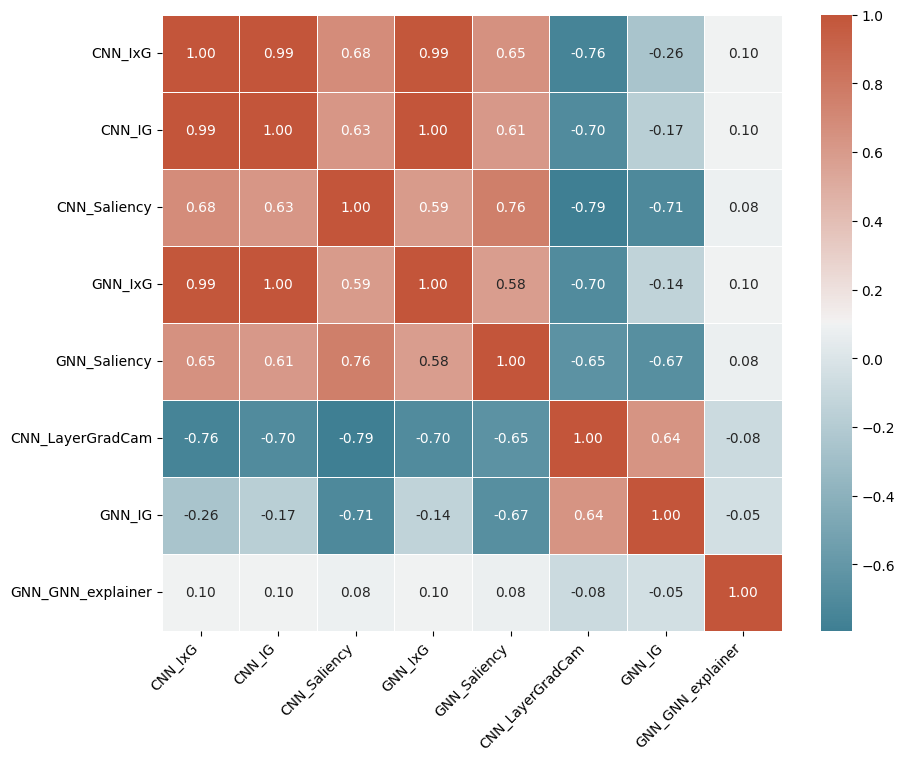

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

res.rename(columns=lambda x: x.replace('DeepCNNSiLU_9L', 'CNN').replace('GraphZSAGEConv_11L', 'GNN'), inplace=True)

corr_matrix = res[['CNN_IxG', 'CNN_IG', 'CNN_Saliency', 
       'GNN_IxG',  'GNN_Saliency', 'CNN_LayerGradCam', 'GNN_IG', 'GNN_GNN_explainer']].corr()

# Построение тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=sns.diverging_palette(220, 20, as_cmap=True), linewidths=0.5)
plt.xticks(rotation=45, ha="right")  # ha="right" для выравнивания справа
plt.yticks(rotation=0)  # Подписи оси Y остаются горизонтальными

plt.show()

## Тепловая карта CNN

In [126]:
df_cnn.rename(columns=lambda x: x.replace('DeepCNNSiLU_9L', 'CNN').replace('GraphZSAGEConv_11L', 'GNN'), inplace=True)

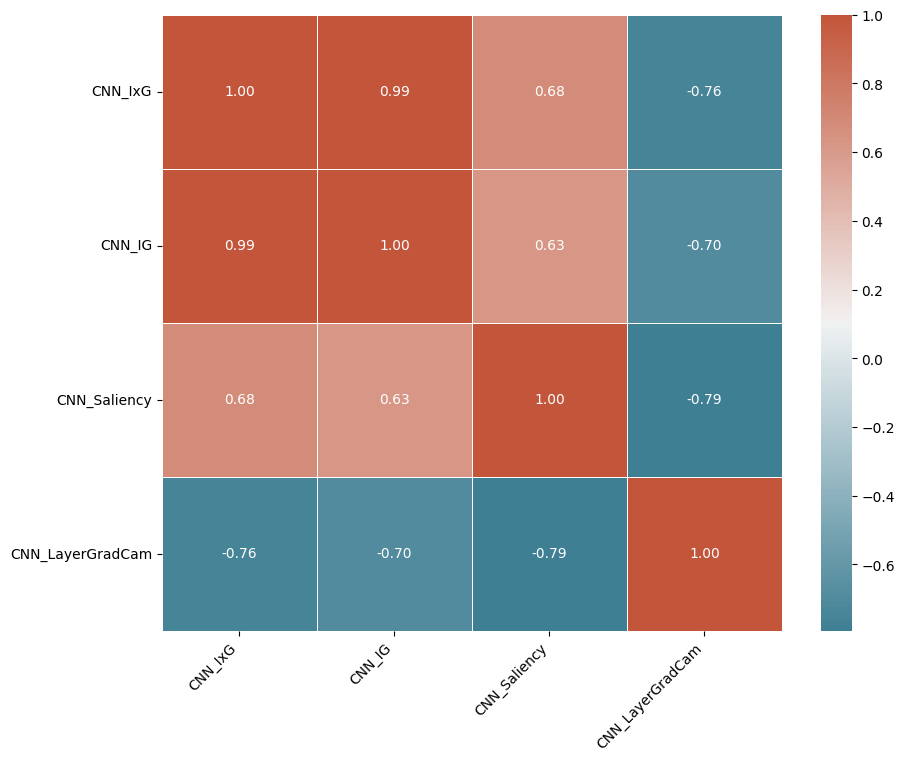

In [127]:
corr_matrix = df_cnn[['CNN_IxG', 'CNN_IG', 'CNN_Saliency', 
       'CNN_LayerGradCam', ]].corr()


# Построение тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=sns.diverging_palette(220, 20, as_cmap=True), linewidths=0.5)
plt.xticks(rotation=45, ha="right")  # ha="right" для выравнивания справа
plt.yticks(rotation=0)  # Подписи оси Y остаются горизонтальными

plt.show()

## Тепловая карта GNN

In [36]:
df_gnn.rename(columns=lambda x: x.replace('DeepCNNSiLU_9L', 'CNN').replace('GraphZSAGEConv_11L', 'GNN'), inplace=True)

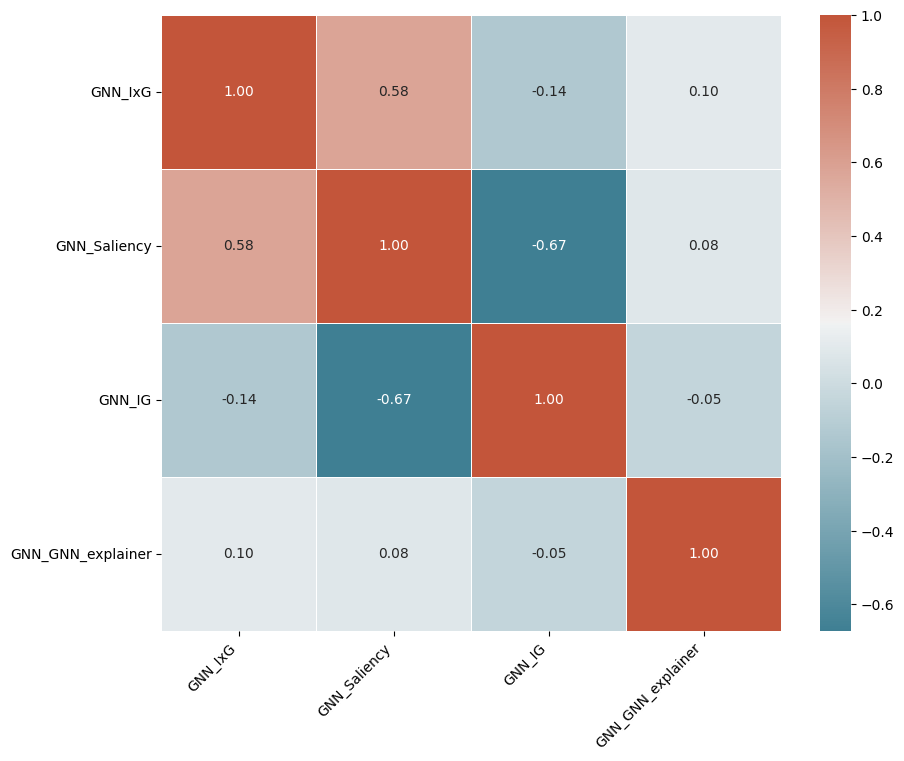

In [38]:
corr_matrix = df_gnn[[ 'GNN_IxG',  'GNN_Saliency', 'GNN_IG', 'GNN_GNN_explainer']].corr()


# Построение тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=sns.diverging_palette(220, 20, as_cmap=True), linewidths=0.5)
plt.xticks(rotation=45, ha="right")  # ha="right" для выравнивания справа
plt.yticks(rotation=0)  # Подписи оси Y остаются горизонтальными

plt.show()